In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Load datasets
customer_profile_path = "test/Customer_Profile_Model.csv"
social_sentiment_path = "test/Social_Media_Sentiment_Model.csv"
transaction_history_path = "test/Transaction_History_Model.csv"

customer_profile_df = pd.read_csv(customer_profile_path)
social_sentiment_df = pd.read_csv(social_sentiment_path)
transaction_history_df = pd.read_csv(transaction_history_path)

# Data Preprocessing
customer_profile_df.fillna(0, inplace=True)  # Handling missing values
social_sentiment_df.fillna(0, inplace=True)  # Handling missing values
transaction_history_df.fillna(0, inplace=True)  # Handling missing values





In [7]:
# Merge datasets
merged_df = customer_profile_df.merge(transaction_history_df, on='Customer_Id', how='left')
merged_df = merged_df.merge(social_sentiment_df, on='Customer_Id', how='left')



In [8]:
# Feature Engineering
merged_df['total_spent'] = merged_df.groupby('Customer_Id')['Amount(In Dollars)'].transform('sum')
merged_df['avg_spent'] = merged_df.groupby('Customer_Id')['Amount(In Dollars)'].transform('mean')
merged_df['transaction_count'] = merged_df.groupby('Customer_Id')['Product_Id'].transform('count')
merged_df['avg_sentiment'] = merged_df.groupby('Customer_Id')['Sentiment_Score'].transform('mean')


In [17]:
# Selecting relevant features for clustering
features = merged_df[['total_spent', 'avg_spent', 'transaction_count', 'avg_sentiment']].drop_duplicates()
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # Replace 'mean' with 'median' or other strategies if needed
X_imputed = imputer.fit_transform(features_scaled)  # Replace NaN values in your dataset

# import numpy as np
# X_cleaned = X[~np.isnan(X).any(axis=1)]  # Remove rows with NaN



In [18]:
# Customer Segmentation using K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
# features['cluster'] = kmeans.fit_predict(features_scaled)
features['cluster'] = kmeans.fit_predict(X_imputed)


In [19]:
# Assigning clusters back to main dataframe
merged_df = merged_df.merge(features, on=['total_spent', 'avg_spent', 'transaction_count', 'avg_sentiment'], how='left')


In [44]:
# Predicting Bank Product Suitability
# Creating target variable based on spending pattern and sentiment
# merged_df['recommended_product'] = np.where((merged_df['total_spent'] > 5000) & (merged_df['avg_sentiment'] > 0), 'Premium Card', 'Basic Card')
# merged_df['recommended_product'] = np.where((merged_df['total_spent'] > 99000) & (merged_df['avg_sentiment'] > .5), 'Premium Card', 'Basic Card')
# merged_df['recommended_product'] = np.where(merged_df['total_spent'] < 5.0, 'Basic Card', 'Premium Card')
merged_df['recommended_product'] = np.where(merged_df['avg_sentiment'] > 0 , 'Premium Card', 'Basic Card')


X = merged_df[['total_spent', 'avg_spent', 'transaction_count', 'avg_sentiment']]
# .drop_duplicates()
y = merged_df['recommended_product']
# .drop_duplicates()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Accuracy: 1.0
              precision    recall  f1-score   support

  Basic Card       1.00      1.00      1.00      1419
Premium Card       1.00      1.00      1.00      1625

    accuracy                           1.00      3044
   macro avg       1.00      1.00      1.00      3044
weighted avg       1.00      1.00      1.00      3044



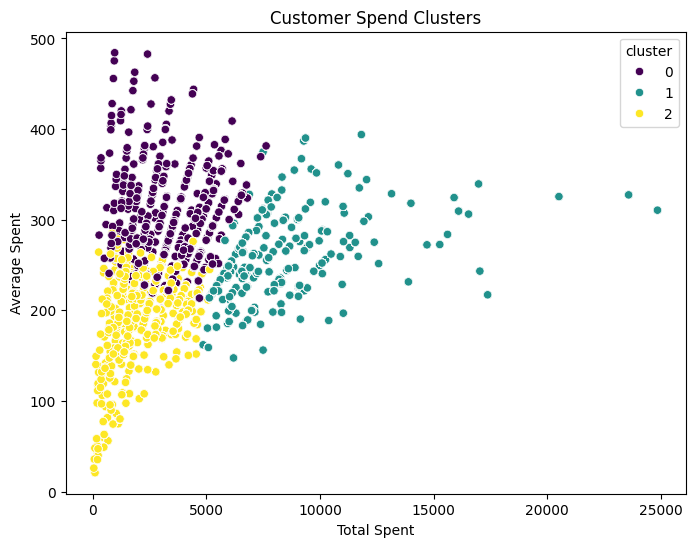

In [45]:
# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Model Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualizing Clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=merged_df['total_spent'], y=merged_df['avg_spent'], hue=merged_df['cluster'], palette='viridis')
plt.xlabel('Total Spent')
plt.ylabel('Average Spent')
plt.title('Customer Spend Clusters')
plt.show()
